## Predicting Telugu Bigg Boss (బిగ్ బాస్ తెలుగు) Season 4 Winner

## Using Python scikit learn https://satya-python.blogspot.com/

### Importing Required Python Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

### Check and import dataset

In [2]:
!cd /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada; ls -tlr

total 72
-rw-r--r-- 1 nobody nogroup 70637 Sep 14 14:01 Bigg_Boss_India.csv


In [3]:
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")
nRow, nCol = bigg_boss.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 589 rows and 21 columns


## Exploratory Data Analysis (EDA)

In [4]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,3.0,0.0,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,6.0,0.0,0.0,0.0


In [5]:
bigg_boss.tail(10).T

,579,580,581,582,583,584,585,586,587,588
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,2,2,2,2,2,2,2,2,2,2
Name,Sujo Mathew,Suresh Krishnan,Thesni Khan,Veena Nair,Daya Ashwathy/Achu,Jazla Madassery,Pavan Gino Thomas,Sooraj,Abhirami Suresh,Amrutha Suresh
Profession,Model,Film Director,Actress,Actress,Social Media Star,Activist,Model,Radio Jockey,Actress,Singer
Gender,Male,Male,Female,Female,Female,Female,Male,Male,Female,Female
Entry Date,05-Jan-20,05-Jan-20,05-Jan-20,05-Jan-20,26-Jan-20,26-Jan-20,NaN,NaN,NaN,NaN
Elimination Date,NaN,26-Jan-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,NaN,3,4,NaN,NaN,8,NaN,8,NaN,NaN
Wild Card,No,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes
Season Length,105,105,105,105,105,105,105,105,105,105


In [6]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
587,Malayalam,2,Abhirami Suresh,Actress,Female,NaN,NaN,NaN,Yes,105,23,05-Jan-20,19-Apr-20,Mohanlal,NaN,Asianet,11.03,3.0,0.0,0.0,NaN
571,Malayalam,2,Pareekutty Perumbavoor,Actor,Male,05-Jan-20,26-Jan-20,3.0,No,105,23,05-Jan-20,19-Apr-20,Mohanlal,0,Asianet,11.03,1.0,0.0,0.0,0.0
257,Kannada,2,Laya Kokila,Comedian,Male,29-Jun-14,NaN,4.0,No,98,15,29-Jun-14,5-Oct-14,Sudeep,0,Suvarna,NaN,2.0,0.0,0.0,0.0
524,Bengali,1,Mallika Majumdar,Actress,Female,17-Jun-13,NaN,11.0,No,90,15,17-Jun-13,14-Sep-13,Mithun Chakraborthy,0,ETV Bangla,2.90,NaN,NaN,NaN,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
401,Telugu,3,Jaffar Babu,TV Anchor,Male,21-Jul-19,04-Aug-19,2.0,No,105,17,21-Jul-19,03-Nov-19,Nagarjuna,0,Star Maa,NaN,2.0,0.0,0.0,0.0
282,Kannada,3,Gowthami Gowda,Actress,Female,NaN,NaN,12.0,Yes,98,18,25-Oct-15,31-Jan-16,Sudeep,0,Colors Kannada,NaN,2.0,0.0,1.0,0.0
176,Hindi,11,Arshi Khan,Actress,Female,01-Oct-17,NaN,12.0,No,106,19,01-Oct-17,14-Jan-18,Salman Khan,0,Colors,7.64,2.0,0.0,1.0,0.0
322,Kannada,6,Adam Pasha,LGBT,Transgender,21-Oct-18,NaN,4.0,No,100,20,21-Oct-18,27-Jan-19,Sudeep,0,Colors Kannada,NaN,4.0,0.0,0.0,0.0
301,Kannada,4,Masthan Chandra,Actor,Male,NaN,NaN,NaN,Yes,112,18,09-Oct-16,29-Jan-17,Sudeep,0,Colors Kannada,NaN,NaN,NaN,NaN,0.0


In [7]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 21 columns):
Language                              589 non-null object
Season Number                         589 non-null int64
Name                                  589 non-null object
Profession                            589 non-null object
Gender                                589 non-null object
Entry Date                            507 non-null object
Elimination Date                      106 non-null object
Elimination Week Number               477 non-null float64
Wild Card                             589 non-null object
Season Length                         589 non-null int64
Number of Housemates                  589 non-null int64
Season Start Date                     589 non-null object
Season End Date                       572 non-null object
Host Name                             589 non-null object
Prize Money (INR)                     563 non-null object
Broadcasted By             

In [8]:
bigg_boss.describe()

,Season Number,Elimination Week Number,Season Length,Number of Housemates,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
count,589.000000,477.000000,589.000000,589.000000,375.000000,532.000000,525.000000,510.000000,563.000000
mean,4.604414,9.098532,102.018676,18.064516,5.780187,3.904135,0.095238,0.545098,0.055062
std,3.541500,4.743941,11.011496,2.138706,2.687312,2.774687,0.306538,0.765749,0.228304
min,1.000000,1.000000,70.000000,15.000000,2.720000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,98.000000,16.000000,3.540000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,9.000000,105.000000,18.000000,4.700000,3.000000,0.000000,0.000000,0.000000
75%,7.000000,14.000000,105.000000,20.000000,8.200000,6.000000,0.000000,1.000000,0.000000
max,13.000000,20.000000,140.000000,23.000000,11.030000,13.000000,2.000000,5.000000,1.000000


In [9]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col,"-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 13
Number of unique values in Name - 587
Number of unique values in Profession - 74
Number of unique values in Gender - 3
Number of unique values in Entry Date - 40
Number of unique values in Elimination Date - 57
Number of unique values in Elimination Week Number - 19
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 13
Number of unique values in Number of Housemates - 8
Number of unique values in Season Start Date - 33
Number of unique values in Season End Date - 30
Number of unique values in Host Name - 15
Number of unique values in Prize Money (INR) - 4
Number of unique values in Broadcasted By - 11
Number of unique values in Average TRP - 20
Number of unique values in Number of Evictions Faced - 14
Number of unique values in Number of re-entries - 3
Number of unique values in Number of times elected as Captain - 6
Number of unique values in Winner - 2


In [10]:
# Number of seasons in all Indian languages
print(bigg_boss.groupby('Language')['Season Number'].nunique().sum())

# 33 seasons happened (including current seasons)

33


## https://www.kaggle.com/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

## Bigg Boss Hindi has many seasons compared to other Indian languages. So, number of housemates are more in Hindi.

In [11]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        13
Kannada       7
Telugu        4
Tamil         3
Bengali       2
Malayalam     2
Marathi       2
Name: Season Number, dtype: int64


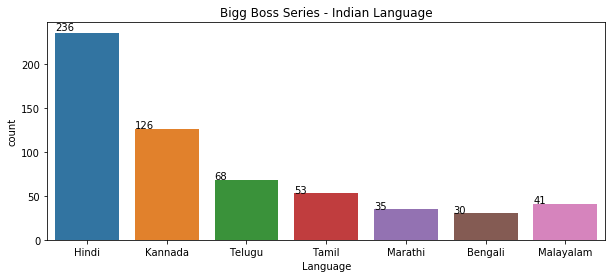

In [12]:
# Total number of Bigg Boss housemates
fig = plt.figure(figsize=(10,4))
ax = sns.countplot(x='Language', data=bigg_boss)
ax.set_title('Bigg Boss Series - Indian Language')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## In Bigg Boss India seasons, most of the housemates entered in first day/week

No     496
Yes     93
Name: Wild Card, dtype: int64 

No     84.0
Yes    16.0
Name: Wild Card, dtype: float64


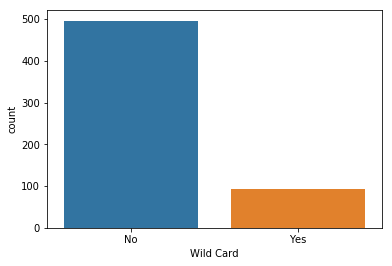

In [13]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100))
sns.countplot(x='Wild Card', data=bigg_boss)

In [14]:
# Common people has many professions, so clubbing them into one category
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession']='Commoner'

## Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions 

Actress                  136
Actor                     97
Model                     44
Soap Actress              40
Commoner                  39
Singer                    32
Soap Actor                28
TV Anchor                 21
Reality Show Alumni       16
Comedian                  13
News Presenter            12
Radio Jockey              12
Social Media Star          9
Choreographer              8
Sports Person              7
Film Director              7
International Star         6
LGBT                       5
Swamiji                    4
Politician                 4
Producer                   4
Pageant Winner             4
Activist                   4
Controversial Fame         4
Wrestler                   3
Businessman                2
Video Jockey               2
Dancer                     2
Journalist                 2
Fashion Designer           2
Stage Actress              2
Lawyer                     1
Numerologist               1
Lyricist                   1
Gym Trainer   

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 49 Text xticklabel objects>)

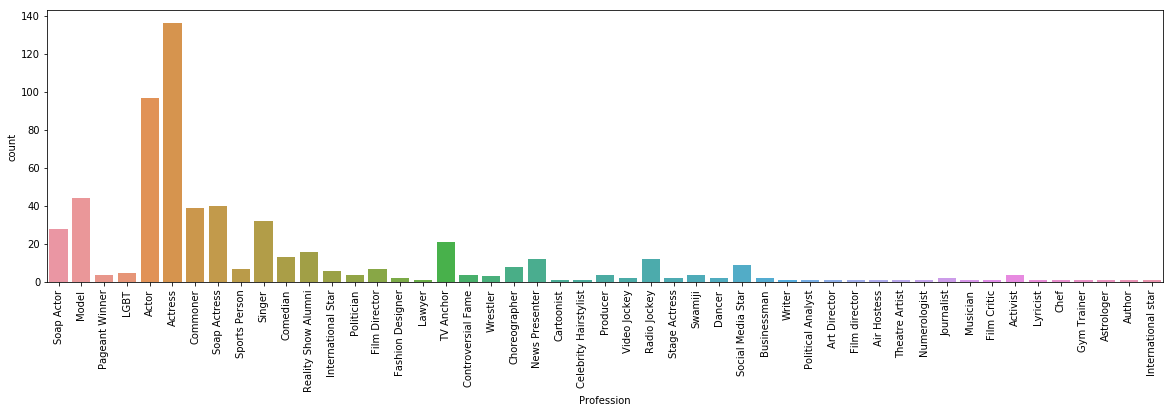

In [15]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20,5))
sns.countplot(x='Profession', data=bigg_boss)
plt.xticks(rotation=90)

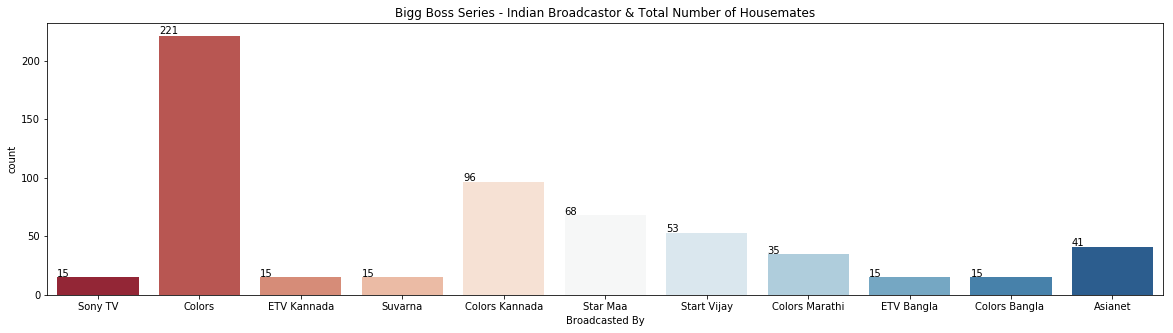

In [16]:
# Broadcastor
fig = plt.figure(figsize=(20,5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu')
ax.set_title('Bigg Boss Series - Indian Broadcastor & Total Number of Housemates')
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next in the list

In [17]:
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan                8
Sudeep                     7
Kamal Haasan               3
Mahesh Manjrekar           2
Mohanlal                   2
Nagarjuna                  2
Amitabh Bachchan           1
Arshad Warsi               1
Jeet                       1
Jr. NTR                    1
Mithun Chakraborthy        1
Nani                       1
Salman Khan/Farah Khan     1
Salman Khan/Sanjay Dutt    1
Shilpa Shetty              1
Name: Season Number, dtype: int64

## In all Bigg Boss competetions, in languages and in all seasons, Female contestants are more

In [18]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts())


Female         308
Male           276
Transgender      5
Name: Gender, dtype: int64


### Only 5 Transgenders participated in all Indian languages

In [19]:
# Maximum TRP of Bigg Boss Hindi/India seasons
print("Maximum TRP",bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 11.03 

  Language  Season Number
 Malayalam              2


In [20]:
# Longest season of Bigg Boss Hindi/India seasons
print("Longest season",bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 140 days 

Language  Season Number
   Hindi             13


## https://satya-data.blogspot.com/2018/01/bigg-boss-data-set-bigg-boss.html

## Only about Winners

In [21]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
8,Hindi,1,Rahul Roy,Actor,Male,03-Nov-06,NaN,NaN,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,"1,00,00,000",Sony TV,2.72,4.0,0.0,0.0,1.0
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,17-Aug-08,NaN,NaN,No,98,15,17-Aug-08,22-Nov-08,Shilpa Shetty,"1,00,00,000",Colors,2.89,4.0,0.0,0.0,1.0
42,Hindi,3,Vindu Dara Singh,Actor,Male,04-Oct-09,NaN,NaN,No,84,15,04-Oct-09,26-Dec-09,Amitabh Bachchan,"1,00,00,000",Colors,2.83,7.0,0.0,0.0,1.0
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,03-Oct-10,NaN,NaN,No,96,16,03-Oct-10,08-Jan-11,Salman Khan,"1,00,00,000",Colors,4.95,4.0,0.0,2.0,1.0
62,Hindi,5,Juhi Parmar,Soap Actress,Female,02-Oct-11,NaN,NaN,No,98,18,02-Oct-11,07-Jan-12,Salman Khan/Sanjay Dutt,"1,00,00,000",Colors,4.19,4.0,0.0,1.0,1.0
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,07-Oct-12,NaN,NaN,No,97,19,07-Oct-12,12-Jan-13,Salman Khan,"50,00,000",Colors,3.81,6.0,0.0,1.0,1.0
102,Hindi,7,Gauhar Khan,Actress,Female,15-Sep-13,NaN,NaN,No,105,20,15-Sep-13,28-Dec-13,Salman Khan,"50,00,000",Colors,4.40,7.0,0.0,2.0,1.0
121,Hindi,8,Gautam Gulati,Actor,Male,21-Sep-14,NaN,NaN,No,105,19,21-Sep-14,03-Jan-15,Salman Khan/Farah Khan,"50,00,000",Colors,3.77,10.0,0.0,1.0,1.0
144,Hindi,9,Prince Narula,Reality Show Alumni,Male,11-Oct-15,NaN,NaN,No,105,20,11-Oct-15,23-Jan-16,Salman Khan,"50,00,000",Colors,2.90,6.0,0.0,4.0,1.0
165,Hindi,10,Manveer Gurjar,Commoner,Male,16-Oct-16,NaN,NaN,No,105,18,16-Oct-16,28-Jan-17,Salman Khan,"50,00,000",Colors,3.54,7.0,0.0,4.0,1.0


In [22]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Profession'].value_counts()

Actor                  7
Actress                5
Singer                 4
Soap Actress           4
Reality Show Alumni    3
TV Anchor              2
Commoner               2
Soap Actor             2
Film Director          1
Model                  1
Name: Profession, dtype: int64

In [23]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(),'\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1,'Gender'].value_counts(normalize=True)*100))

# Male      22
# Female     9

Male      22
Female     9
Name: Gender, dtype: int64 

Male      71.0
Female    29.0
Name: Gender, dtype: float64


## No wild card entry housemate won the Bigg Boss competition.

In [24]:
# Entry type of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1,'Wild Card'].value_counts()

No    31
Name: Wild Card, dtype: int64

In [25]:
# No re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1,'Number of re-entries'].value_counts()

0.0    28
Name: Number of re-entries, dtype: int64

In [26]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1,'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

4.0     7
5.0     3
6.0     5
7.0     5
8.0     1
9.0     3
10.0    1
11.0    2
12.0    1
Name: Number of Evictions Faced, dtype: int64

In [27]:
# Bigg Boss title winner number of times elected as Captain
bigg_boss.loc[bigg_boss.Winner==1,'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain   - Number of winners

0.0    6
1.0    9
2.0    9
3.0    1
4.0    2
Name: Number of times elected as Captain, dtype: int64

## BB Telugu Seasons

In [28]:
lang='Telugu'

# All Bigg Boss Telugu Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
362,Telugu,1,Aadarsh Balakrishna,Actor,Male,16-Jul-17,24-Sep-17,10.0,No,70,16,16-Jul-17,24-Sep-17,Jr. NTR,0,Star Maa,NaN,4.0,0.0,1.0,0.0
363,Telugu,1,Archana,Actress,Female,16-Jul-17,24-Sep-17,10.0,No,70,16,16-Jul-17,24-Sep-17,Jr. NTR,0,Star Maa,NaN,6.0,0.0,0.0,0.0
364,Telugu,1,Dhanraj,Comedian,Male,16-Jul-17,26-Aug-17,6.0,No,70,16,16-Jul-17,24-Sep-17,Jr. NTR,0,Star Maa,NaN,3.0,0.0,0.0,0.0
365,Telugu,1,Hari Teja,Actress,Female,16-Jul-17,24-Sep-17,10.0,No,70,16,16-Jul-17,24-Sep-17,Jr. NTR,0,Star Maa,NaN,6.0,0.0,1.0,0.0
366,Telugu,1,Jyothi,Actress,Female,16-Jul-17,23-Jul-17,1.0,No,70,16,16-Jul-17,24-Sep-17,Jr. NTR,0,Star Maa,NaN,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,Telugu,4,Noel Sean,Singer,Male,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,1.0,NaN,NaN,NaN
426,Telugu,4,Sujatha,News Presenter,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,1.0,NaN,NaN,NaN
427,Telugu,4,Surya Kiran,Film Director,Male,06-Sep-20,13-Sep-20,1.0,No,105,16,06-Sep-20,NaN,Nagarjuna,0,Star Maa,NaN,1.0,0.0,0.0,0.0
428,Telugu,4,Syed Sohel Ryan,Soap Actor,Male,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN


In [29]:
# Bigg Boss Telugu Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
375,Telugu,1,Siva Balaji,Actor,Male,16-Jul-17,NaN,NaN,No,70,16,16-Jul-17,24-Sep-17,Jr. NTR,"50,00,000",Star Maa,NaN,4.0,0.0,2.0,1.0
385,Telugu,2,Kaushal Manda,Actor,Male,10-Jun-18,NaN,NaN,No,112,18,10-Jun-18,30-Sep-18,Nani,"50,00,000",Star Maa,NaN,11.0,0.0,1.0,1.0
404,Telugu,3,Rahul Sipligunj,Singer,Male,21-Jul-19,NaN,NaN,No,105,17,21-Jul-19,03-Nov-19,Nagarjuna,"50,00,000",Star Maa,NaN,11.0,0.0,0.0,1.0


In [30]:
# Bigg Boss Telugu current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
413,Telugu,4,Abijeet,Actor,Male,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,1.0,NaN,NaN,NaN
414,Telugu,4,Akhil Sarthak,Model,Male,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,1.0,NaN,NaN,NaN
415,Telugu,4,Alekya Harika,Social Media Star,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN
416,Telugu,4,Amma Rajasekhar,Choreographer,Male,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN
417,Telugu,4,Ariyana Glory,TV Anchor,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN
418,Telugu,4,Devi Nagavalli,News Presenter,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN
419,Telugu,4,Divi Vadthaya,Model,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,1.0,NaN,NaN,NaN
420,Telugu,4,Gangavva,Social Media Star,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,1.0,NaN,NaN,NaN
421,Telugu,4,Karate Kalyani,Actress,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,NaN,NaN,NaN,NaN
422,Telugu,4,Lasya,TV Anchor,Female,06-Sep-20,NaN,NaN,No,105,16,06-Sep-20,NaN,Nagarjuna,NaN,Star Maa,NaN,NaN,NaN,1.0,NaN


## Preparing Data for ML modelling

In [31]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                             82
Elimination Date                      483
Elimination Week Number               112
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                        17
Host Name                               0
Prize Money (INR)                      26
Broadcasted By                          0
Average TRP                           214
Number of Evictions Faced              57
Number of re-entries                   64
Number of times elected as Captain     79
Winner                                 26
dtype: int64

In [32]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [33]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

In [34]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [35]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,2.72,3.0,0.0,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
3,Hindi,1,Bobby Darling,LGBT,Transgender,2006-11-03,NaT,1.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12.0,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,0,Sony TV,2.72,6.0,0.0,0.0,0.0


In [36]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
584,Malayalam,2,Jazla Madassery,Activist,Female,2020-01-26,NaT,8.0,Yes,105,23,2020-01-05,2020-04-19,Mohanlal,0,Asianet,11.03,4.0,0.0,0.0,0.0
585,Malayalam,2,Pavan Gino Thomas,Model,Male,NaT,NaT,NaN,Yes,105,23,2020-01-05,2020-04-19,Mohanlal,0,Asianet,11.03,0.0,0.0,0.0,0.0
586,Malayalam,2,Sooraj,Radio Jockey,Male,NaT,NaT,8.0,Yes,105,23,2020-01-05,2020-04-19,Mohanlal,0,Asianet,11.03,2.0,0.0,0.0,0.0
587,Malayalam,2,Abhirami Suresh,Actress,Female,NaT,NaT,NaN,Yes,105,23,2020-01-05,2020-04-19,Mohanlal,NaN,Asianet,11.03,3.0,0.0,0.0,NaN
588,Malayalam,2,Amrutha Suresh,Singer,Female,NaT,NaT,NaN,Yes,105,23,2020-01-05,2020-04-19,Mohanlal,NaN,Asianet,11.03,3.0,0.0,0.0,NaN


In [37]:
# Updating last week-end elimination/entries manually


In [38]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
481,Tamil,3,Meera Mitun,Model,Female,NaT,NaT,5.0,Yes,105,17,2019-06-23,2019-10-06,Kamal Haasan,0,Start Vijay,8.800000,4.0,0.0,0.0,0.0
229,Hindi,13,Khesari Lal Yadav,Actor,Male,NaT,NaT,8.0,Yes,140,22,2019-09-29,2020-02-15,Salman Khan,0,Colors,9.060000,2.0,0.0,0.0,0.0
195,Hindi,12,Deepak Thakur,Singer,Male,2018-09-16,2018-12-30,15.0,No,105,20,2018-09-16,2018-12-30,Salman Khan,0,Colors,4.990000,7.0,0.0,1.0,0.0
301,Kannada,4,Masthan Chandra,Actor,Male,NaT,NaT,NaN,Yes,112,18,2016-10-09,2017-01-29,Sudeep,0,Colors Kannada,5.780187,1.0,0.0,NaN,0.0
542,Bengali,2,Priya Paul,Soap Actress,Female,2016-04-04,NaT,NaN,No,97,15,2016-04-04,2016-07-15,Jeet,0,Colors Bangla,6.500000,1.0,0.0,NaN,0.0
521,Bengali,1,Kais Kalim,Gym Trainer,Male,2013-06-17,NaT,1.0,No,90,15,2013-06-17,2013-09-14,Mithun Chakraborthy,0,ETV Bangla,2.900000,1.0,0.0,NaN,0.0
149,Hindi,9,Vikas Bhalla,Actor,Male,2015-10-11,NaT,3.0,No,105,20,2015-10-11,2016-01-23,Salman Khan,0,Colors,2.900000,2.0,0.0,1.0,0.0
555,Malayalam,1,Diya Sana,Activist,Female,2018-06-24,NaT,6.0,No,98,18,2018-06-24,2018-09-30,Mohanlal,0,Asianet,10.330000,2.0,0.0,0.0,0.0
227,Hindi,13,Vikas Pathak,Social Media Star,Male,NaT,NaT,11.0,Yes,140,22,2019-09-29,2020-02-15,Salman Khan,0,Colors,9.060000,2.0,0.0,0.0,0.0
124,Hindi,8,Natasa Stankovic,Model,Female,2014-09-21,NaT,4.0,No,105,19,2014-09-21,2015-01-03,Salman Khan/Farah Khan,0,Colors,3.770000,2.0,0.0,0.0,0.0


In [39]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Telugu season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
413,Telugu,4,Abijeet,Actor,Male,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
414,Telugu,4,Akhil Sarthak,Model,Male,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
415,Telugu,4,Alekya Harika,Social Media Star,Female,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
416,Telugu,4,Amma Rajasekhar,Choreographer,Male,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
417,Telugu,4,Ariyana Glory,TV Anchor,Female,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
418,Telugu,4,Devi Nagavalli,News Presenter,Female,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
419,Telugu,4,Divi Vadthaya,Model,Female,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
420,Telugu,4,Gangavva,Social Media Star,Female,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
421,Telugu,4,Karate Kalyani,Actress,Female,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN,NaN
422,Telugu,4,Lasya,TV Anchor,Female,2020-09-06,NaT,NaN,No,105,16,2020-09-06,NaT,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,1.0,NaN


In [40]:
BB_telugu_participant = test[['Name']]
BB_telugu_participant.reset_index(drop=True, inplace=True)
BB_telugu_participant

,Name
0,Abijeet
1,Akhil Sarthak
2,Alekya Harika
3,Amma Rajasekhar
4,Ariyana Glory
5,Devi Nagavalli
6,Divi Vadthaya
7,Gangavva
8,Karate Kalyani
9,Lasya


In [41]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Elimination Week Number"], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Elimination Week Number","Winner"], axis=1, inplace=True)

In [42]:
train.head()

,Language,Season Number,Profession,Gender,Wild Card,Season Length,Number of Housemates,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain,Winner
0,Hindi,1,Soap Actor,Male,No,86,15,Arshad Warsi,0,Sony TV,2.72,3.0,0.0,0.0,0.0
1,Hindi,1,Model,Female,No,86,15,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
2,Hindi,1,Pageant Winner,Male,No,86,15,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
3,Hindi,1,LGBT,Transgender,No,86,15,Arshad Warsi,0,Sony TV,2.72,1.0,0.0,0.0,0.0
4,Hindi,1,Model,Female,No,86,15,Arshad Warsi,0,Sony TV,2.72,6.0,0.0,0.0,0.0


In [43]:
test.head()

,Language,Season Number,Profession,Gender,Wild Card,Season Length,Number of Housemates,Host Name,Prize Money (INR),Broadcasted By,Average TRP,Number of Evictions Faced,Number of re-entries,Number of times elected as Captain
413,Telugu,4,Actor,Male,No,105,16,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN
414,Telugu,4,Model,Male,No,105,16,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN
415,Telugu,4,Social Media Star,Female,No,105,16,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN
416,Telugu,4,Choreographer,Male,No,105,16,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN
417,Telugu,4,TV Anchor,Female,No,105,16,Nagarjuna,NaN,Star Maa,5.780187,1.0,0.0,NaN


In [44]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.493783
1.0     5.506217
Name: Winner, dtype: float64


In [45]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [46]:
print(train2.shape)
print(test.shape)

(563, 155)
(16, 155)


In [47]:
train2.isnull().sum().sort_values(ascending=False)

Number of times elected as Captain_5.0    0
Profession_Pageant Winner                 0
Profession_Soap Actor                     0
Profession_Singer                         0
Profession_Reality Show Alumni            0
                                         ..
Prize Money (INR)_1,00,00,000             0
Host Name_Sudeep                          0
Host Name_Shilpa Shetty                   0
Host Name_Salman Khan/Sanjay Dutt         0
Language_Hindi                            0
Length: 155, dtype: int64

In [48]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Profession_Actor,Profession_Actress,Profession_Air Hostess,Profession_Art Director,Profession_Astrologer,Profession_Author,Profession_Businessman,...,Average TRP_8.2,Average TRP_8.8,Average TRP_9.06,Average TRP_10.33,Average TRP_11.03,Number of Evictions Faced_1.0,Number of Evictions Faced_2.0,Number of Evictions Faced_3.0,Number of Evictions Faced_4.0,Number of Evictions Faced_5.0,Number of Evictions Faced_6.0,Number of Evictions Faced_7.0,Number of Evictions Faced_8.0,Number of Evictions Faced_9.0,Number of Evictions Faced_10.0,Number of Evictions Faced_11.0,Number of Evictions Faced_12.0,Number of Evictions Faced_13.0,Number of re-entries_1.0,Number of re-entries_2.0,Number of times elected as Captain_1.0,Number of times elected as Captain_2.0,Number of times elected as Captain_3.0,Number of times elected as Captain_4.0,Number of times elected as Captain_5.0
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.

In [50]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=2019)
print(x_train.shape, x_val.shape)

(394, 155) (169, 155)


## Machine Learning Modelling

In [51]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues');
    ax.set_xlabel('True Label',size=12)
    ax.set_ylabel('Predicted Label',size=12)

In [52]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2020, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 88.61538461538463
F1 score for C=1: 96.71254087657873
F1 score for C=10: 98.11753463927379
F1 score for C=100: 100.0
F1 score for C=1000: 100.0


In [53]:
logi = LogisticRegression(random_state=2020,C=100).fit(x_train, y_train)
logi

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2020, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 100.0
Accuracy Score - 100.0


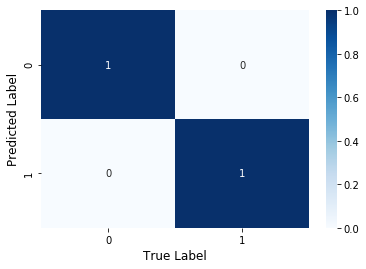

In [55]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 1

In [56]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
12,Noel Sean,0.000513
14,Syed Sohel Ryan,0.000412
4,Ariyana Glory,0.000340
9,Lasya,0.000332
10,Mehaboob Dil Se,0.000150
3,Amma Rajasekhar,0.000139
0,Abijeet,0.000118
1,Akhil Sarthak,0.000115
2,Alekya Harika,0.000087
7,Gangavva,0.000087


## Predicted Winner for Bigg Boss Telugu Season 4, as per Logistic Regression

In [57]:
# Predicted Winner for Bigg Boss Telugu Season 4, as per LogisticRegression
winner_lg.iloc[np.argwhere(winner_lg.Predicted_Winner == np.amax(winner_lg.Predicted_Winner)).flatten().tolist()]

,Name,Predicted_Winner
12,Noel Sean,0.000513


In [58]:
# RandomForest
rf = RandomForestClassifier(n_estimators=500, random_state=2020).fit(x_train, y_train)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)

In [59]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=200 accuracy 98.22
# n_estimators=500 accuracy 100

F1 Score - 100.0
Accuracy Score - 100.0


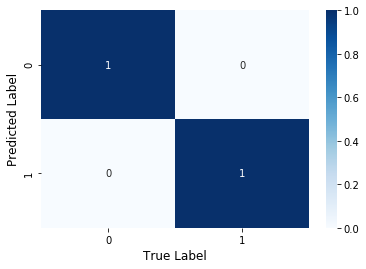

In [60]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 1

In [61]:
predicted_val_rf = rf.predict_proba(test)[:,1]
winner_rf = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False)

,Name,Predicted_Winner
0,Abijeet,0.020
12,Noel Sean,0.020
14,Syed Sohel Ryan,0.020
15,Kumar Sai,0.018
1,Akhil Sarthak,0.014
3,Amma Rajasekhar,0.014
10,Mehaboob Dil Se,0.014
2,Alekya Harika,0.006
5,Devi Nagavalli,0.006
6,Divi Vadthaya,0.006


## Predicted Winner for Bigg Boss Telugu Season 4, as per Random Forest

In [62]:
# Predicted Winner for Bigg Boss Telugu Season 4, as per RandomForest
winner_rf.iloc[np.argwhere(winner_rf.Predicted_Winner == np.amax(winner_rf.Predicted_Winner)).flatten().tolist()]

,Name,Predicted_Winner
0,Abijeet,0.02
12,Noel Sean,0.02
14,Syed Sohel Ryan,0.02


## Neaural Networks (MLP)

In [63]:
NN = MLPClassifier(random_state=2020)
#NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(500, 20), random_state=2020)
NN.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2020, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [64]:
predicted_val_nn = NN.predict(x_val)
# predicted_val_nn = NN.predict_proba(x_val)[:,1]
# y_predicted_val = (predicted_val_nn > 0.03).astype("int").ravel()
print('F1 Score -',f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -',accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 100.0
Accuracy Score - 100.0


In [65]:
predicted_val_nn

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

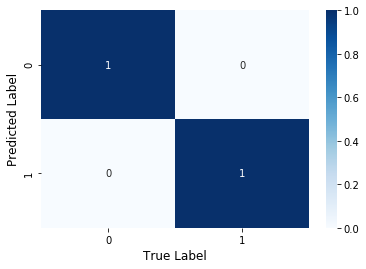

In [66]:
# Confusion Matrix
plot_confusion_matrix()

In [67]:
predicted_val_nn = NN.predict(test)
winner = pd.concat([BB_telugu_participant, pd.DataFrame(predicted_val_nn, columns=['Predicted_Winner'])],axis=1)
winner[['Name','Predicted_Winner']]

,Name,Predicted_Winner
0,Abijeet,0.0
1,Akhil Sarthak,0.0
2,Alekya Harika,0.0
3,Amma Rajasekhar,0.0
4,Ariyana Glory,0.0
5,Devi Nagavalli,0.0
6,Divi Vadthaya,0.0
7,Gangavva,0.0
8,Karate Kalyani,0.0
9,Lasya,0.0


In [68]:
# Predicted Winner for Bigg Boss Telugu Season 4, as per Neaural Networks (Multi Layer Perceptron)
# winner.iloc[winner.Predicted_Winner.argmax()]['Name']